In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import xgboost, shap, math

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
X,y = shap.datasets.boston()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [3]:
X_train.shape

(379, 13)

In [4]:
%time rf_model = RandomForestRegressor().fit(X_train, y_train)

CPU times: user 39 ms, sys: 3.68 ms, total: 42.7 ms
Wall time: 47.6 ms


In [5]:
%time rf_model2 = RandomForestRegressor(n_estimators=40,min_samples_leaf=3).fit(X_train, y_train)

CPU times: user 110 ms, sys: 4.09 ms, total: 114 ms
Wall time: 113 ms


In [6]:
%time xg_model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train, label=y_train), 100)

[17:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[17:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[17:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[17:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[17:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[17:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[17:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[17:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[17:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

In [7]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
xg_explainer = shap.TreeExplainer(xg_model)
xg_shap_values = xg_explainer.shap_values(X)

In [8]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
rf_explainer = shap.TreeExplainer(rf_model)
rf_shap_values = rf_explainer.shap_values(X)

In [9]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    train_err = rmse(m.predict(X_train), y_train)
    train_score = m.score(X_train, y_train)
    test_err = rmse(m.predict(X_test), y_test)
    test_score =  m.score(X_test, y_test)
    print('Train RMSE: {}, Train Accuracy: {}'.format(train_err,train_score))
    print('Validation RMSE: {}, Validation Accuracy: {}'.format(test_err,test_score))
    if hasattr(m, 'oob_score_'):
        print('OOB Score: {}'.format(m.oob_score_))

In [10]:
print_score(rf_model)

Train RMSE: 1.4610507839017237, Train Accuracy: 0.9731058580967769
Validation RMSE: 3.182547387552265, Validation Accuracy: 0.897751221977058


In [11]:
print_score(rf_model2)

Train RMSE: 2.032035259349309, Train Accuracy: 0.9479777001829032
Validation RMSE: 3.24645233328233, Validation Accuracy: 0.8936037233986316


In [12]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(xg_explainer.expected_value, xg_shap_values[25,:], X.iloc[25,:])

In [13]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(rf_explainer.expected_value, rf_shap_values[25,:], X.iloc[25,:])

In [14]:
# visualize the training set predictions
shap.force_plot(xg_explainer.expected_value, xg_shap_values, X)

In [15]:
# visualize the training set predictions
shap.force_plot(rf_explainer.expected_value, rf_shap_values, X)

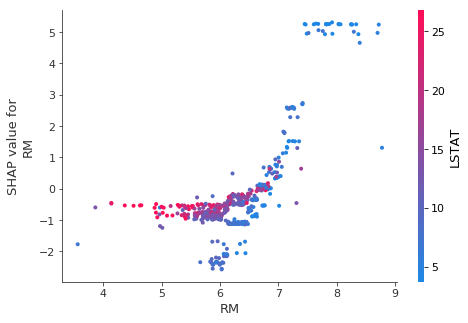

In [16]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("RM", xg_shap_values, X)

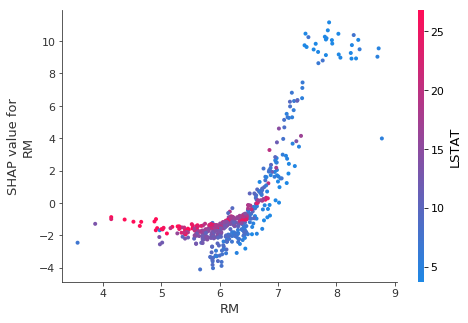

In [17]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("RM", rf_shap_values, X)

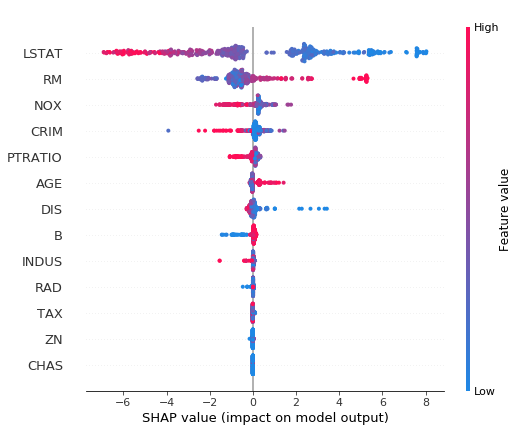

In [18]:
# summarize the effects of all the features
shap.summary_plot(xg_shap_values, X)

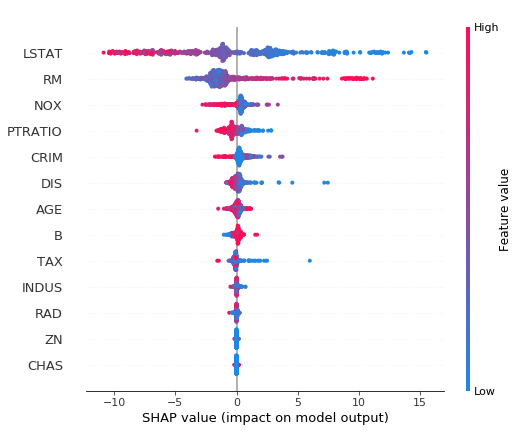

In [19]:
# summarize the effects of all the features
shap.summary_plot(rf_shap_values, X)

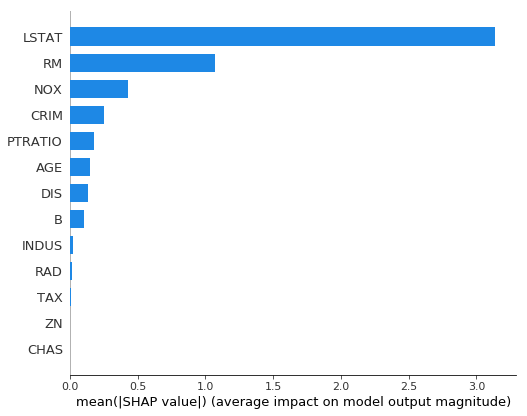

In [20]:
# summarize the effects of all the features
shap.summary_plot(xg_shap_values, X,plot_type='bar')

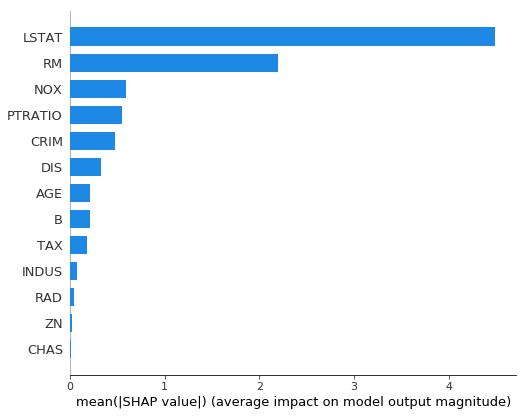

In [21]:
# summarize the effects of all the features
shap.summary_plot(rf_shap_values, X,plot_type='bar')

In [22]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'importance':m.feature_importances_}
                       ).sort_values('importance', ascending=False)
def plot_fi(fi):
    return fi.plot('cols', 'importance', 'barh', figsize=(12,7), legend=False)

In [23]:
feat_imp_df = rf_feat_importance(rf_model,X_train)
feat_imp_df

,cols,importance
12,LSTAT,0.538687
5,RM,0.251542
7,DIS,0.044855
0,CRIM,0.044437
4,NOX,0.033780
10,PTRATIO,0.028331
6,AGE,0.020625
11,B,0.016106
9,TAX,0.013579
2,INDUS,0.004321


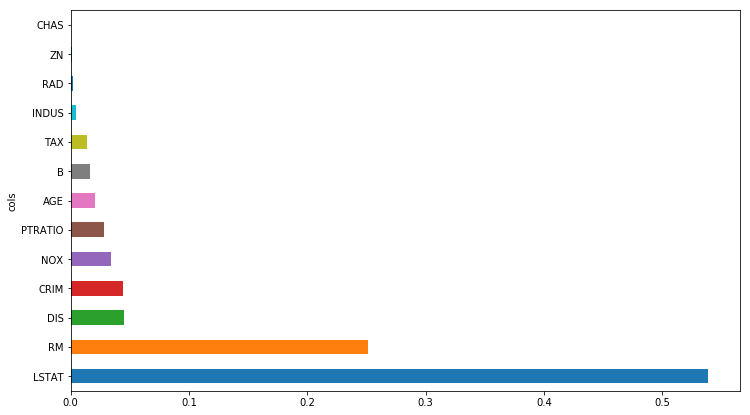

In [24]:
plot_fi(feat_imp_df);

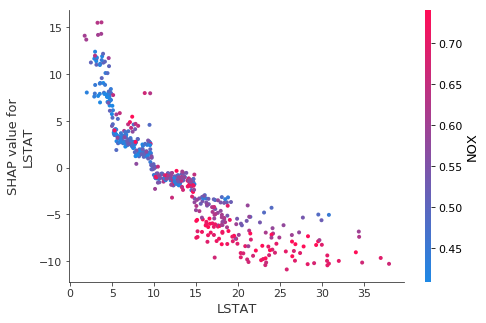

In [25]:
shap.dependence_plot("LSTAT", rf_shap_values, X)